# **1. Project and Dataset Selection**

In [122]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [123]:
# Set the url to raw github link and read in the garments worker dataset using the link
url = "https://raw.githubusercontent.com/Sarvesh30/CS4372-Project-1/refs/heads/main/garments_worker_productivity.csv"
worker_df = pd.read_csv(url)

# The garment worker dataset on UCI ML consists of features such as worker departments,
#   number of workers in each team, targeted productivity, financial incentives,
#   and worker time efficency metrics to predict team productity performance on a
#   continuous scale from 0 to 1.

# **2. Regression Model Building**

## **2.1 Pre-Processing**

In [124]:
# First, get a general view of the dataset using .head()
worker_df.head()

# The data is arranged in terms of the productivity for each day, quarter,
#   department, and team

# Check for null values in the dataset
print(worker_df.isnull().sum())

# The wip (work in progress) variable has 506 entries of null values. Therefore,
#   we will drop this variable from the dataset.
worker_df = worker_df.drop(columns = ['wip'])

date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64


In [125]:
# Remove white space after "finishing"
worker_df['department'] = worker_df['department'].str.strip()

In [126]:
# Looking through the dataset the idle_time, incentive, idle_men, and no_of_style_change
#   attributes contain many zeros. We can examine this further.

cols = ['idle_time', 'incentive', 'idle_men', 'no_of_style_change']
for col in cols:
  print(col)
  print(worker_df[col].value_counts())

# Idle_time (1179/1197 are zero --> represents no interruption in production)
# Incentive (604/1197 are zero --> represents zero financial incentive in BDT)
# Idle_men (1179/1197 are zero --> represents no idle men during production)
# no_of_style_change (1050/1197 are zero --> represents zero style changes in the product)

idle_time
idle_time
0.0      1179
3.5         3
2.0         2
8.0         2
4.0         2
4.5         2
5.0         2
90.0        1
270.0       1
150.0       1
300.0       1
6.5         1
Name: count, dtype: int64
incentive
incentive
0       604
50      113
63       61
45       54
30       52
23       38
38       29
60       28
40       27
75       24
113      21
88       19
34       17
56       14
26        9
55        7
81        7
100       7
65        6
69        6
70        6
960       5
35        5
44        4
94        4
90        3
49        2
27        2
46        2
119       2
24        2
98        1
29        1
54        1
37        1
21        1
138       1
33        1
53        1
93        1
62        1
32        1
1080      1
2880      1
3600      1
1440      1
1200      1
25        1
Name: count, dtype: int64
idle_men
idle_men
0     1179
10       3
15       3
30       3
20       3
35       2
37       1
45       1
25       1
40       1
Name: count, dtype: int64
no_of_styl

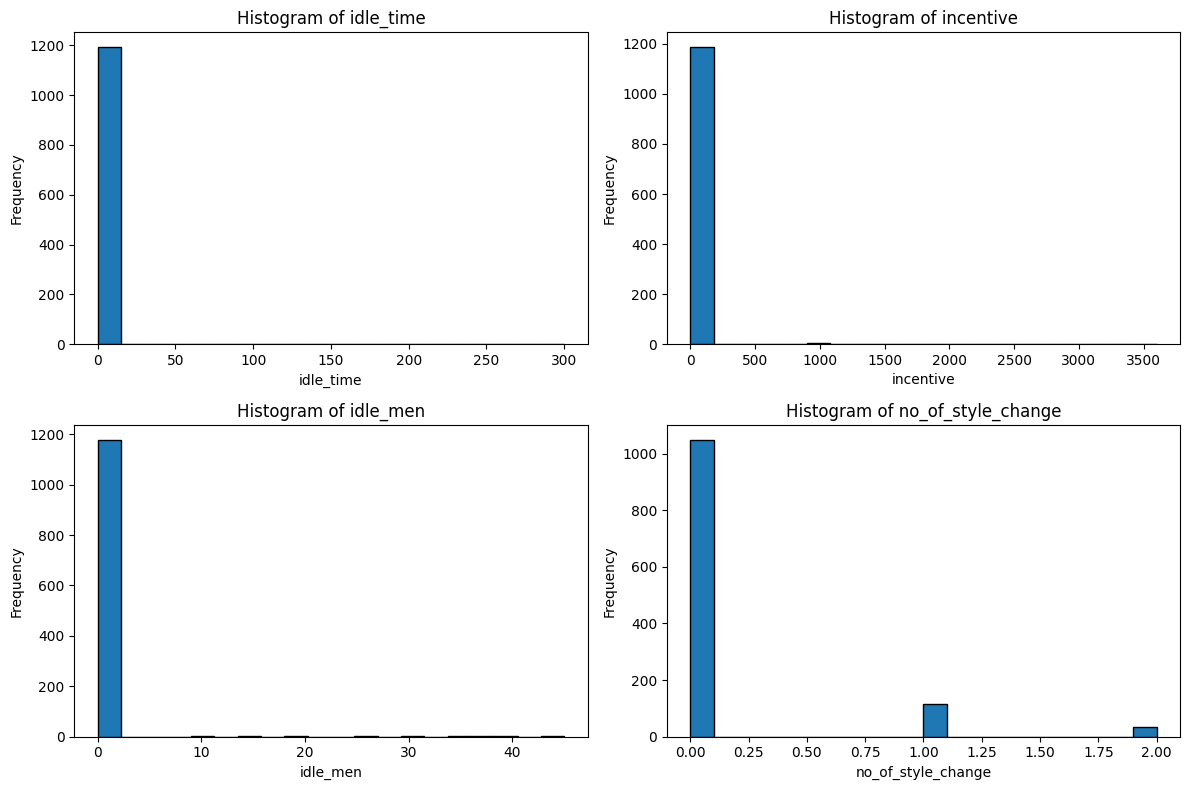

In [127]:
# Create a histogram plot for each of the variables in cols
plt.figure(figsize=(12, 8))

for i, col in enumerate(cols, 1):
    plt.subplot(2, 2, i)  # 2x2 grid of subplots
    plt.hist(worker_df[col], bins=20, edgecolor='black')
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [128]:
# Provides a statistical summary for the numerical features in worker_df
worker_df.describe()

# The idle_time, idle_men, and no_of_style_change features seem to be right skewed
#   as their min, lower quartile, median, and upper quartile values are zero. This
#   should be considered when building models.

,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,3.463963,0.097891,10.943219,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,6.000000,0.750000,15.260000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,9.000000,0.800000,24.260000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,12.000000,0.800000,54.560000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


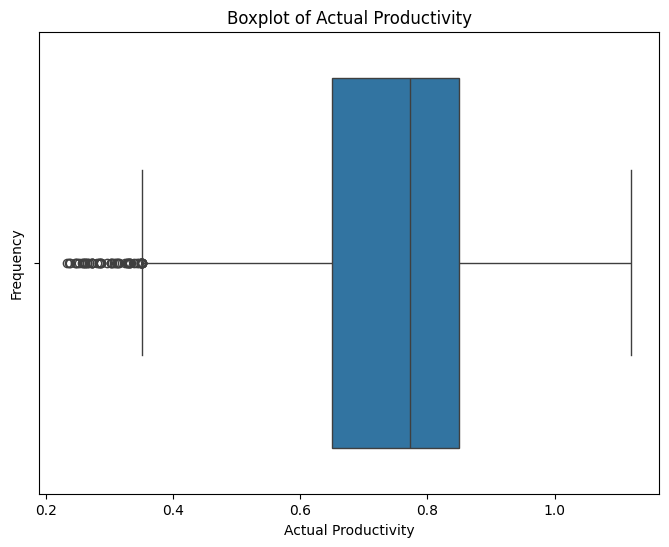

In [129]:
# Create a boxplot of the actual productivity
plt.figure(figsize=(8, 6))
sns.boxplot(x=worker_df['actual_productivity'])
plt.title('Boxplot of Actual Productivity')
plt.xlabel('Actual Productivity')
plt.ylabel('Frequency')
plt.show()

In [130]:
# Create a new data frame which consists of worker faults (productivity <= 0.40)
worker_fault = worker_df[worker_df['actual_productivity'] <= 0.40]

# Find the counts of worker faults grouped by quarter, team, and department

# Count outliers by department
department_counts = worker_fault.groupby('department').size()
print("Outliers by Department:")
print(department_counts)

# Count outliers by quarter
quarter_counts = worker_fault.groupby('quarter').size()
print("\nOutliers by Quarter:")
print(quarter_counts)

# Count outliers by team
team_counts = worker_fault.groupby('team').size()
print("\nOutliers by Team:")
print(team_counts)


Outliers by Department:
department
finishing    40
sweing       41
dtype: int64

Outliers by Quarter:
quarter
Quarter1    16
Quarter2    23
Quarter3    16
Quarter4    24
Quarter5     2
dtype: int64

Outliers by Team:
team
1      2
2      7
3      2
4      3
5      6
6     10
7     12
8     13
9      5
10    10
11     8
12     3
dtype: int64


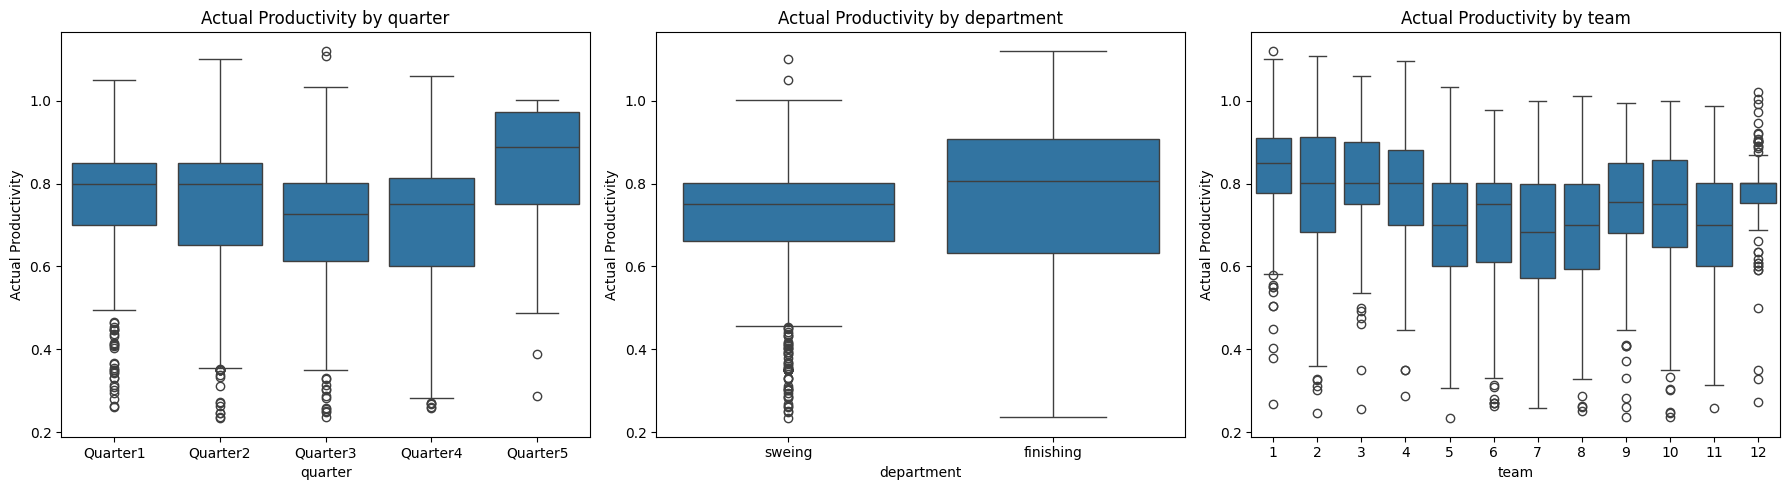

In [131]:
# Create boxplots of the actual productivity against quarter, department, and team
categorical_cols = ['quarter', 'department', 'team']

plt.figure(figsize=(18, 5))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=col, y='actual_productivity', data=worker_df)
    plt.title(f'Actual Productivity by {col}')
    plt.xlabel(col)
    plt.ylabel('Actual Productivity')

plt.tight_layout()
plt.show()

In [132]:
# One-hot encoding will help with determining the direct relationships between
#   the levels of the categorical variables in relation to actual productivity

# Apply one-hot encoding to categorical variables (quarter, department, day, team)
worker_df = pd.get_dummies(worker_df, columns = ['quarter', 'department', 'team'],
                           drop_first = True)

dummy_cols = worker_df.select_dtypes(include='bool').columns
worker_df[dummy_cols] = worker_df[dummy_cols].astype(int)

In [133]:
worker_df

,date,day,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,...,team_3,team_4,team_5,team_6,team_7,team_8,team_9,team_10,team_11,team_12
0,1/1/2015,Thursday,0.80,26.16,7080,98,0.0,0,0,59.0,...,0,0,0,0,0,1,0,0,0,0
1,1/1/2015,Thursday,0.75,3.94,960,0,0.0,0,0,8.0,...,0,0,0,0,0,0,0,0,0,0
2,1/1/2015,Thursday,0.80,11.41,3660,50,0.0,0,0,30.5,...,0,0,0,0,0,0,0,0,1,0
3,1/1/2015,Thursday,0.80,11.41,3660,50,0.0,0,0,30.5,...,0,0,0,0,0,0,0,0,0,1
4,1/1/2015,Thursday,0.80,25.90,1920,50,0.0,0,0,56.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,3/11/2015,Wednesday,0.75,2.90,960,0,0.0,0,0,8.0,...,0,0,0,0,0,0,0,1,0,0
1193,3/11/2015,Wednesday,0.70,3.90,960,0,0.0,0,0,8.0,...,0,0,0,0,0,1,0,0,0,0
1194,3/11/2015,Wednesday,0.65,3.90,960,0,0.0,0,0,8.0,...,0,0,0,0,1,0,0,0,0,0
1195,3/11/2015,Wednesday,0.75,2.90,1800,0,0.0,0,0,15.0,...,0,0,0,0,0,0,1,0,0,0


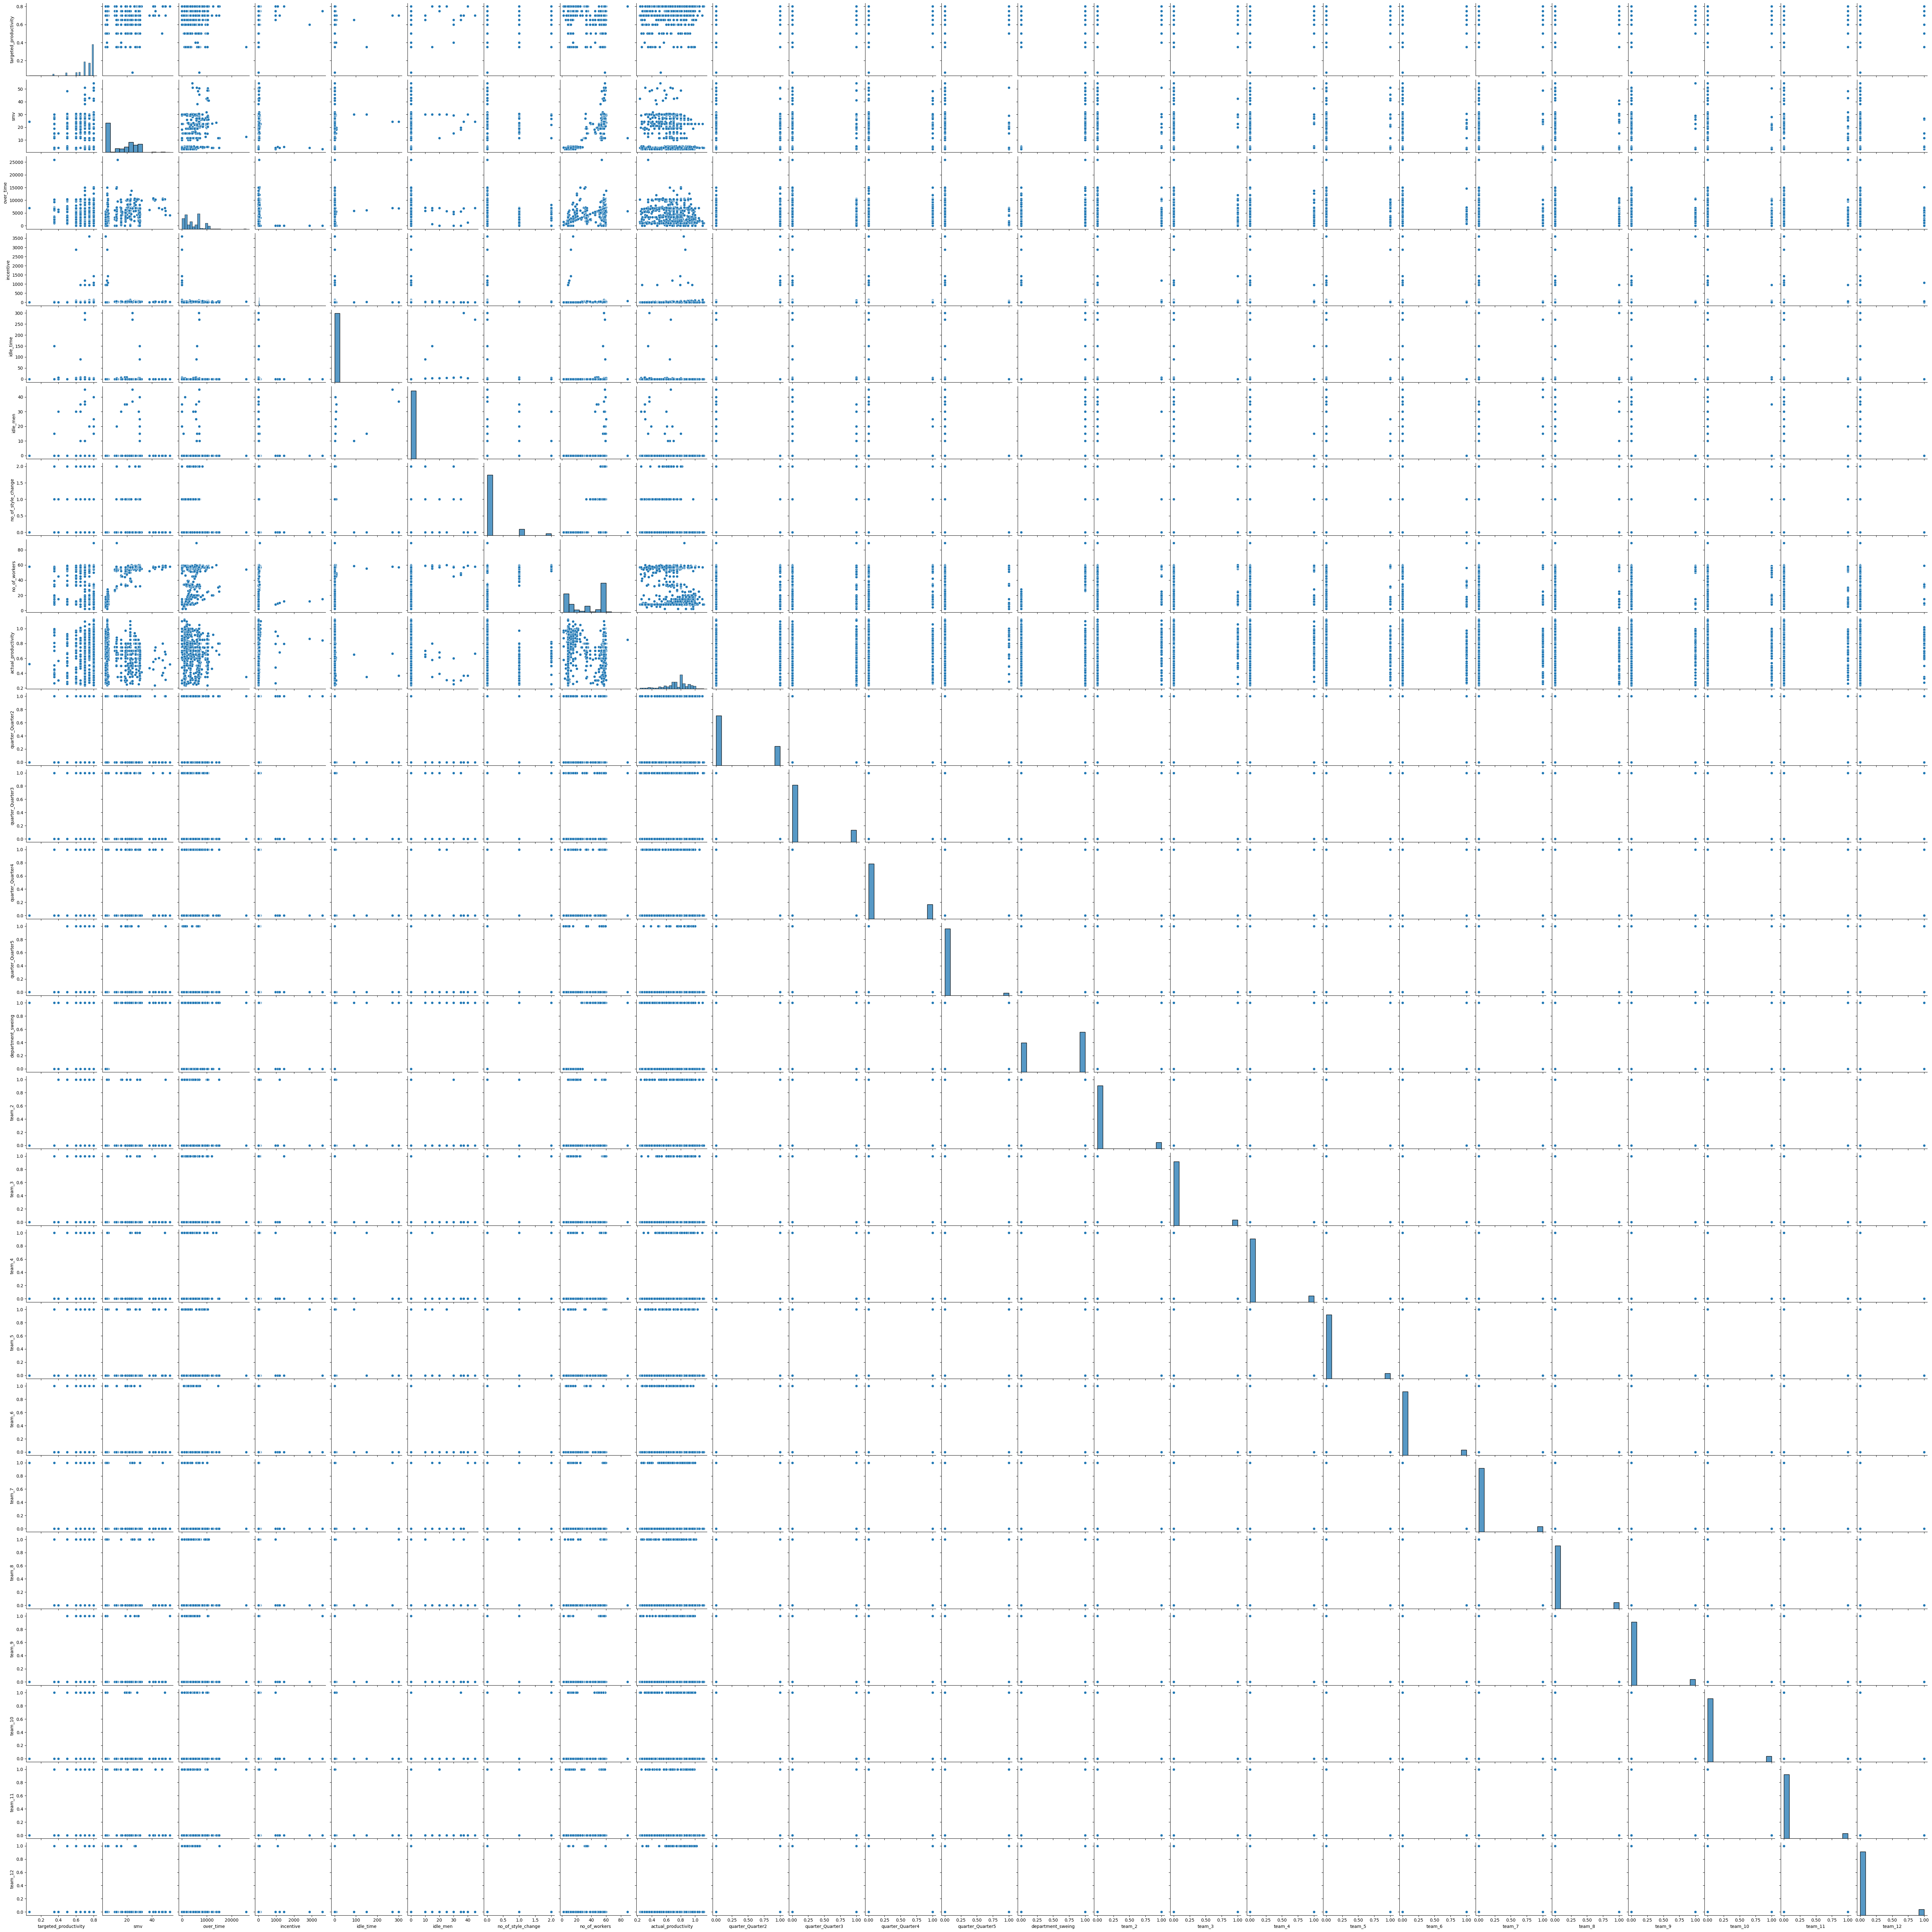

In [ ]:
# Create a pairplot of all attributes
worker_df_pairplot = worker_df.drop(columns = ['date'])
sns.pairplot(worker_df_pairplot)

# We can check the diagonal plots to check for the distribution of each attribute
# The target variable (actual productivity) is slightly skewed left but follows
#   close to a normal distribution

# The idle men, idle time, and no of style change may not be attributes
#   that we include due to their distributions being dominated by one value (0)

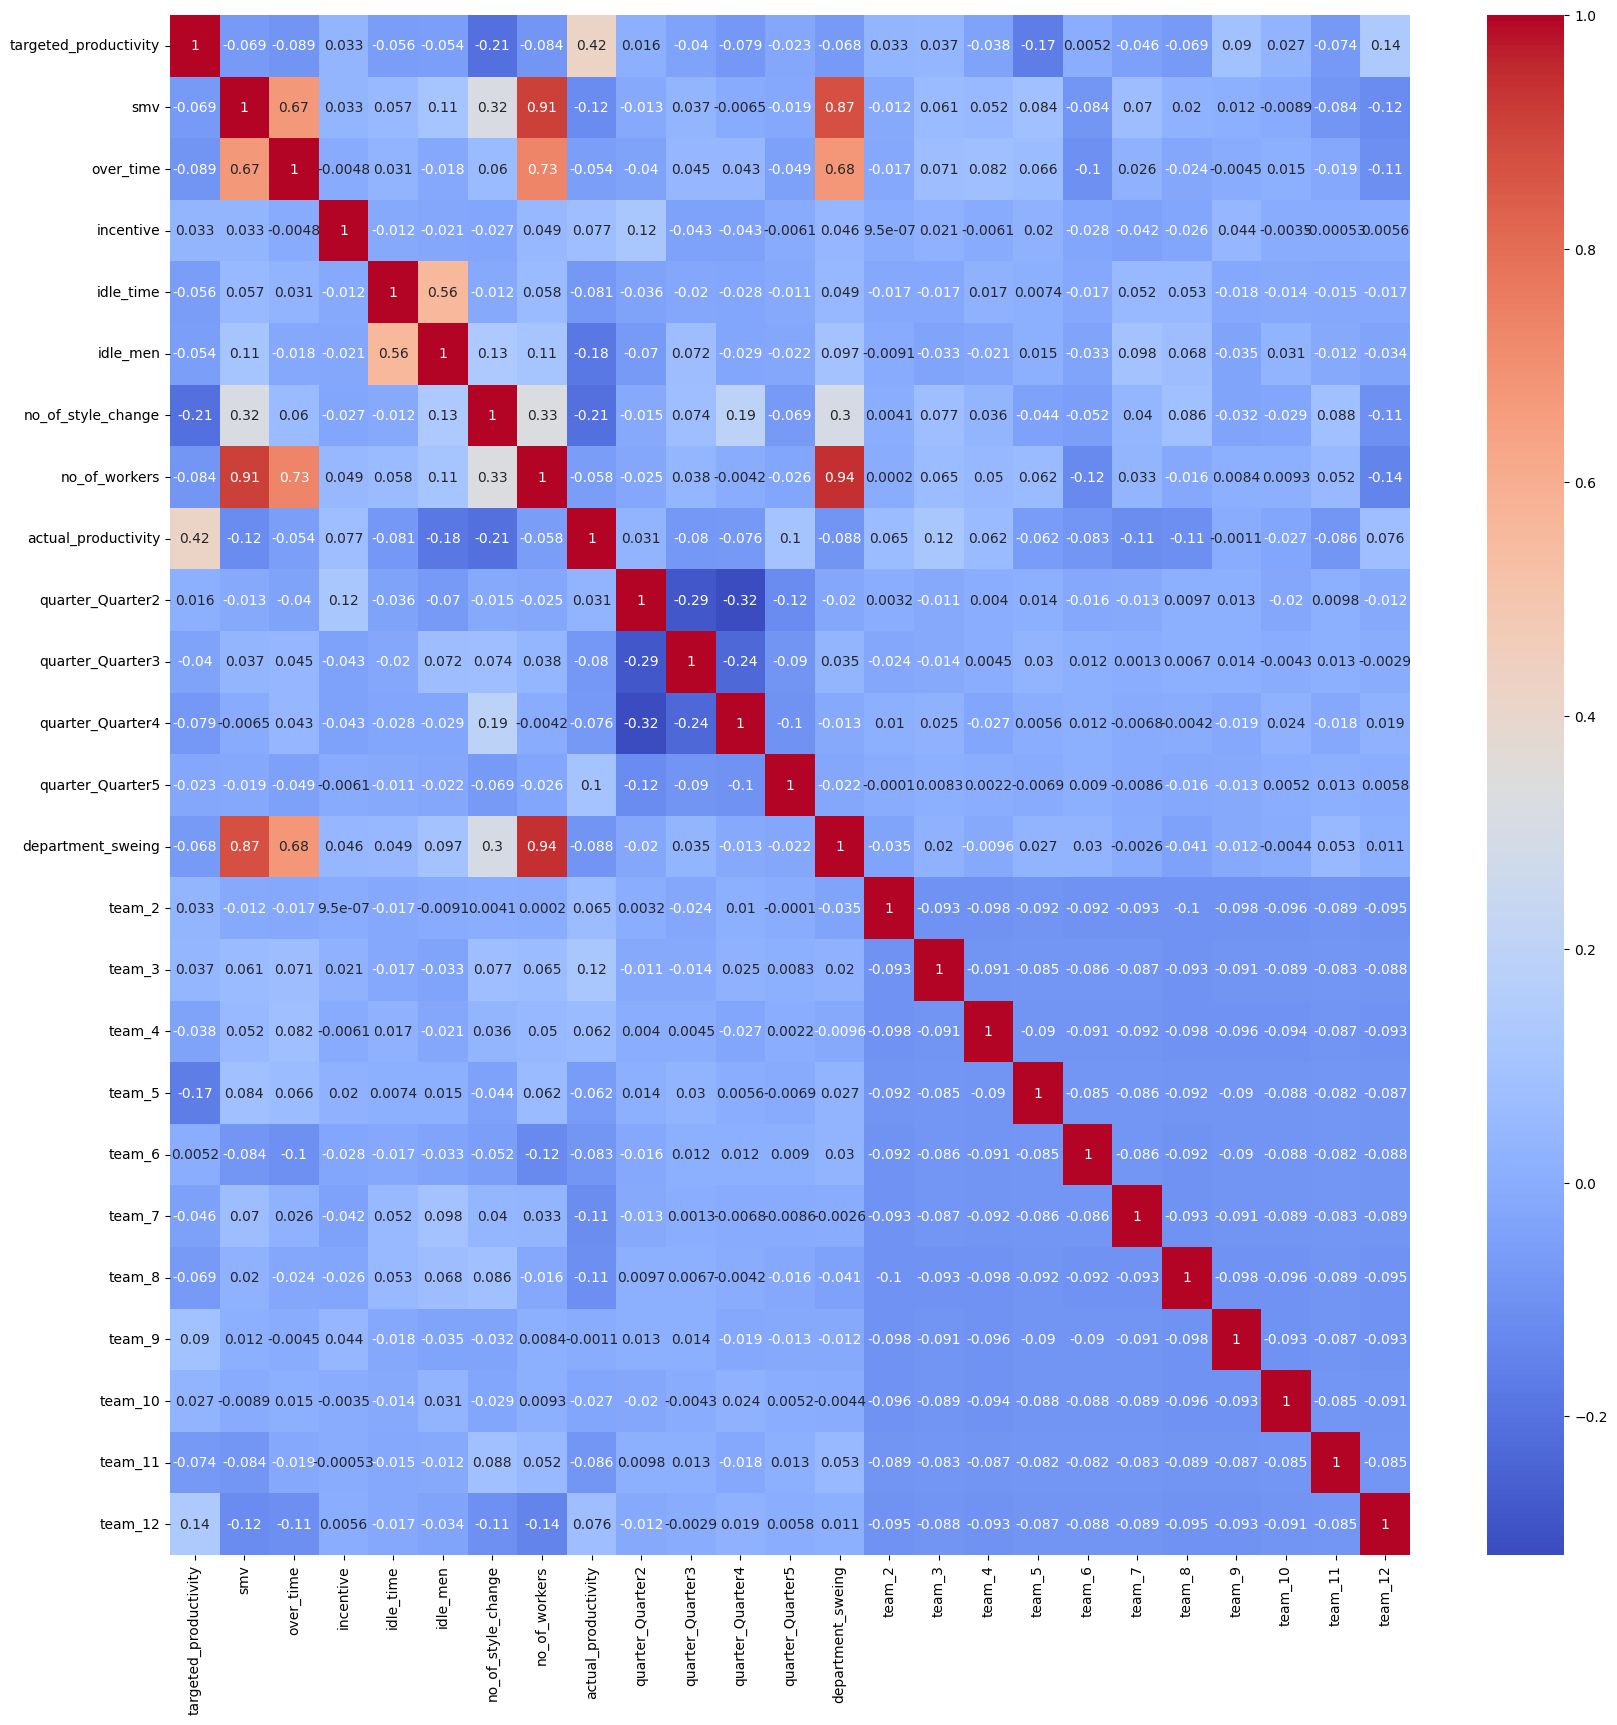

In [134]:
# Create a correlation matrix using the numerical features
numeric_cols = worker_df.select_dtypes(include = 'number').columns
worker_df_num = worker_df[numeric_cols]
corr_matrix = worker_df_num.corr()

# Create a correlation matrix heatmap
plt.figure(figsize = (20, 20))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm')
plt.show()

# Analysis of results:
#   Targeted productivity has a positive, moderate correlation with actual productivity
#   Smv, idle_men and no_of_style_change have a weak, negative, correlation with actual productivity
#   Smv and over_time have a positive, close to strong correlation (possibility for multicollinearity)
#   Over_time and no_of_workers also have a positive, strong relationship
#   No_of_workers and smv have a very strong positive relationship (0.91) --> only include one of the two features

In [135]:
# Split data into training and testing parts

X = worker_df.drop(columns = ['actual_productivity', 'smv', 'no_of_style_change',
                              'idle_time', 'no_of_workers', 'date', 'day'])

y = worker_df['actual_productivity']

# Apply standardization to X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)

# 80/20 training and testing split is used
train_X, test_X, train_y, test_y = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

## **2.2 Model Construction**

In [ ]:
# Building SGD Regressor Model
sgd = SGDRegressor(max_iter=20000, tol=1e-4, random_state = 42)

# Hypertuning parameter grid
param_grid = {
    'alpha' : [0.001, 0.1],
    'max_iter': [15000, 20000],
    'learning_rate' :['constant', 'optimal', 'invscaling'],
    'eta0' :  [0.05, 0.1],
    #'penalty' : ['l1', 'l2', 'elasticnet']
}

# Grid search is used to test different set of parameters for SGD
grid_search = GridSearchCV(sgd, param_grid, cv = 5, scoring = 'neg_mean_squared_error',
                           verbose = 3)
grid_search.fit(train_X, train_y)

# Determine the best SGD model with the best set of parameters
best_sgd = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Make predictions
pred_train = best_sgd.predict(train_X)
pred_test = best_sgd.predict(test_X)

# Display performance metrics for the best model
print("Train R2: ", r2_score(train_y, pred_train))
print("Test R2: ", r2_score(test_y, pred_test))

train_mse = mean_squared_error(train_y, pred_train)
test_mse  = mean_squared_error(test_y, pred_test)

print("Train RMSE", np.sqrt(train_mse))
print("Test RMSE", np.sqrt(test_mse))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END alpha=0.001, eta0=0.05, learning_rate=constant, max_iter=15000;, score=-14166028025522810781696.000 total time=   0.0s
[CV 2/5] END alpha=0.001, eta0=0.05, learning_rate=constant, max_iter=15000;, score=-2732027750464292913152.000 total time=   0.0s
[CV 3/5] END alpha=0.001, eta0=0.05, learning_rate=constant, max_iter=15000;, score=-250862742912401440768.000 total time=   0.0s
[CV 4/5] END alpha=0.001, eta0=0.05, learning_rate=constant, max_iter=15000;, score=-15894781298555335213056.000 total time=   0.0s
[CV 5/5] END alpha=0.001, eta0=0.05, learning_rate=constant, max_iter=15000;, score=-1403758998143205.250 total time=   0.0s
[CV 1/5] END alpha=0.001, eta0=0.05, learning_rate=constant, max_iter=20000;, score=-14166028025522810781696.000 total time=   0.0s
[CV 2/5] END alpha=0.001, eta0=0.05, learning_rate=constant, max_iter=20000;, score=-2732027750464292913152.000 total time=   0.0s
[CV 3/5] END alpha=0.001,

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5] END alpha=0.1, eta0=0.05, learning_rate=optimal, max_iter=15000;, score=-2.800 total time=   1.2s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5] END alpha=0.1, eta0=0.05, learning_rate=optimal, max_iter=15000;, score=-13.272 total time=   1.2s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5] END alpha=0.1, eta0=0.05, learning_rate=optimal, max_iter=15000;, score=-362.238 total time=   1.2s
[CV 4/5] END alpha=0.1, eta0=0.05, learning_rate=optimal, max_iter=15000;, score=-0.610 total time=   1.0s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5] END alpha=0.1, eta0=0.05, learning_rate=optimal, max_iter=15000;, score=-30.919 total time=   1.2s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5] END alpha=0.1, eta0=0.05, learning_rate=optimal, max_iter=20000;, score=-0.940 total time=   1.5s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5] END alpha=0.1, eta0=0.05, learning_rate=optimal, max_iter=20000;, score=-4.763 total time=   2.6s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5] END alpha=0.1, eta0=0.05, learning_rate=optimal, max_iter=20000;, score=-121.704 total time=   1.7s
[CV 4/5] END alpha=0.1, eta0=0.05, learning_rate=optimal, max_iter=20000;, score=-0.610 total time=   1.0s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5] END alpha=0.1, eta0=0.05, learning_rate=optimal, max_iter=20000;, score=-10.276 total time=   1.6s
[CV 1/5] END alpha=0.1, eta0=0.05, learning_rate=invscaling, max_iter=15000;, score=-0.027 total time=   0.0s
[CV 2/5] END alpha=0.1, eta0=0.05, learning_rate=invscaling, max_iter=15000;, score=-0.022 total time=   0.0s
[CV 3/5] END alpha=0.1, eta0=0.05, learning_rate=invscaling, max_iter=15000;, score=-0.026 total time=   0.0s
[CV 4/5] END alpha=0.1, eta0=0.05, learning_rate=invscaling, max_iter=15000;, score=-0.021 total time=   0.0s
[CV 5/5] END alpha=0.1, eta0=0.05, learning_rate=invscaling, max_iter=15000;, score=-0.022 total time=   0.0s
[CV 1/5] END alpha=0.1, eta0=0.05, learning_rate=invscaling, max_iter=20000;, score=-0.027 total time=   0.0s
[CV 2/5] END alpha=0.1, eta0=0.05, learning_rate=invscaling, max_iter=20000;, score=-0.022 total time=   0.0s
[CV 3/5] END alpha=0.1, eta0=0.05, learning_rate=invscaling, max_iter=20000;, score=-0.026 total time=   0.0s
[CV 4/5] END

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5] END alpha=0.1, eta0=0.1, learning_rate=optimal, max_iter=15000;, score=-2.800 total time=   1.2s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5] END alpha=0.1, eta0=0.1, learning_rate=optimal, max_iter=15000;, score=-13.272 total time=   1.2s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5] END alpha=0.1, eta0=0.1, learning_rate=optimal, max_iter=15000;, score=-362.238 total time=   1.2s
[CV 4/5] END alpha=0.1, eta0=0.1, learning_rate=optimal, max_iter=15000;, score=-0.610 total time=   1.0s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5] END alpha=0.1, eta0=0.1, learning_rate=optimal, max_iter=15000;, score=-30.919 total time=   1.2s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5] END alpha=0.1, eta0=0.1, learning_rate=optimal, max_iter=20000;, score=-0.940 total time=   2.4s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5] END alpha=0.1, eta0=0.1, learning_rate=optimal, max_iter=20000;, score=-4.763 total time=   1.9s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5] END alpha=0.1, eta0=0.1, learning_rate=optimal, max_iter=20000;, score=-121.704 total time=   1.6s
[CV 4/5] END alpha=0.1, eta0=0.1, learning_rate=optimal, max_iter=20000;, score=-0.610 total time=   1.0s
[CV 5/5] END alpha=0.1, eta0=0.1, learning_rate=optimal, max_iter=20000;, score=-10.276 total time=   1.5s
[CV 1/5] END alpha=0.1, eta0=0.1, learning_rate=invscaling, max_iter=15000;, score=-0.029 total time=   0.0s
[CV 2/5] END alpha=0.1, eta0=0.1, learning_rate=invscaling, max_iter=15000;, score=-0.024 total time=   0.0s
[CV 3/5] END alpha=0.1, eta0=0.1, learning_rate=invscaling, max_iter=15000;, score=-0.028 total time=   0.0s
[CV 4/5] END alpha=0.1, eta0=0.1, learning_rate=invscaling, max_iter=15000;, score=-0.023 total time=   0.0s
[CV 5/5] END alpha=0.1, eta0=0.1, learning_rate=invscaling, max_iter=15000;, score=-0.023 total time=   0.0s
[CV 1/5] END alpha=0.1, eta0=0.1, learning_rate=invscaling, max_iter=20000;, score=-0.029 total time=   0.0s
[CV 2/5] END alpha=0.1, e

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [136]:
# Build the OLS model using Statsmodels
X_train_sm = sm.add_constant(train_X)
X_test_sm = sm.add_constant(test_X)

model = sm.OLS(train_y, X_train_sm).fit()
print(model.summary())

# Predictions for OLS model
pred_train = model.predict(X_train_sm)
pred_test = model.predict(X_test_sm)

# R squared metrics
r2_train = r2_score(train_y, pred_train)
r2_test  = r2_score(test_y, pred_test)

# RMSE metrics
rmse_train = np.sqrt(mean_squared_error(train_y, pred_train))
rmse_test  = np.sqrt(mean_squared_error(test_y, pred_test))

print("Train R²:", r2_train)
print("Test R²:", r2_test)
print("Train RMSE:", rmse_train)
print("Test RMSE:", rmse_test)

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.294
Model:                             OLS   Adj. R-squared:                  0.279
Method:                  Least Squares   F-statistic:                     19.51
Date:                 Mon, 22 Sep 2025   Prob (F-statistic):           8.47e-58
Time:                         04:11:06   Log-Likelihood:                 465.54
No. Observations:                  957   AIC:                            -889.1
Df Residuals:                      936   BIC:                            -786.9
Df Model:                           20                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

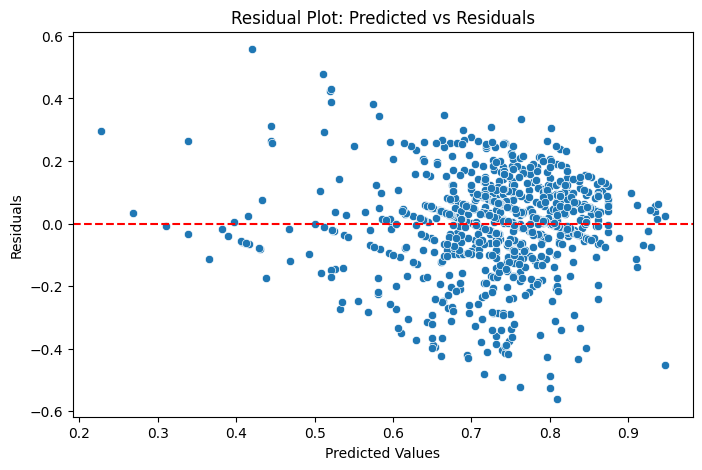

In [ ]:
# Residual plot to assess linearity
residuals = train_y - pred_train

plt.figure(figsize=(8,5))
sns.scatterplot(x=pred_train, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot: Predicted vs Residuals')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define a simple tuning grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Perform Grid Search for Random Forest
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42),
                             param_grid_rf,
                             cv=3,
                             scoring='neg_mean_squared_error',
                             verbose=1,
                             n_jobs=-1) # Use all available cores

grid_search_rf.fit(train_X, train_y)

# Get the best Random Forest model and its parameters
best_rf_model = grid_search_rf.best_estimator_
print("\nBest Random Forest Parameters:", grid_search_rf.best_params_)

# Make predictions with the best model
pred_train_best_rf = best_rf_model.predict(train_X)
pred_test_best_rf = best_rf_model.predict(test_X)

# Evaluate the best Random Forest model
print("Best Random Forest Model Performance:")
print("Train R2:", r2_score(train_y, pred_train_best_rf))
print("Test R2:", r2_score(test_y, pred_test_best_rf))
print("Train RMSE:", np.sqrt(mean_squared_error(train_y, pred_train_best_rf)))
print("Test RMSE:", np.sqrt(mean_squared_error(test_y, pred_test_best_rf)))

Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Random Forest Model Performance:
Train R2: 0.7386441010206242
Test R2: 0.47964850973950557
Train RMSE: 0.09052731014750484
Test RMSE: 0.11754410034390393
